# Part II - Exploration of Ford Go-Bike
## by Ajibola Oyedeji

## Investigation Overview


In this investigation, I wanted to look at the rider patterns across different clusters or segments based on age groups, gender, user type using such measures as distance covered, duration of rides, preffered day and time of rides.


## Dataset Overview

The dataset contains 183,411 bike rides with 16 variables on ride including ride duration, start and end latitude and longitude, user type, age and gender. Get the [dataset here](https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv).

Feature engineering was done to calculate the trip distance in kilometers from the start and end latitudes and longitudes, age, and extract categorical variables such as weekday, time of day and age group.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import time

import mpu  # package to calculate distance

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Default plot settings
base_color = sns.color_palette()[0]

In [2]:
# load in the dataset into a pandas dataframe
bike = pd.read_csv("201902-fordgobike-tripdata.csv")

In [3]:
# Define function to convert columns to category
def to_category(df, cols):
    """Convert selected columns to 'category'. Takes dataframe name and list of columns as inputs"""
    for col in cols:
        df[col] = df[col].astype('category')

# Convert the columns to category
cate = ['start_station_id', 'end_station_id', 'user_type', 'member_gender', 'bike_share_for_all_trip']
to_category(bike, cate)

# Convert bike_id to string
bike['bike_id'] = bike.bike_id.astype(str)

In [4]:
# Calcutate distance of ride in Kilometers
bike['distance_km'] = bike.apply(lambda x: mpu.haversine_distance((x.start_station_latitude, x.start_station_longitude),
                                                               (x.end_station_latitude, x.end_station_longitude)), axis=1)

# Calculate the users age in 2019
bike['age_years'] = 2019 - bike.member_birth_year

# Create age groups
bin = [15, 25, 46, 65, 200]
label = ["Adolescent", "Middle-aged Adult", "Old-aged Adult", "Seniors"]
bike["age_group"] = pd.cut(bike["age_years"], bins=bin, labels=label, right=False)

In [5]:
# Convert time to datetime
bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])

# Get categorical variables from Start time
bike['start_day'] = bike.start_time.dt.date
bike['day'] = bike.start_time.dt.day_name().astype('category')
bike['time_day'] = bike.start_time.dt.hour
bin = [5, 12, 17, 21, 24]
label = ["Morning", "Afternoon", "Evening", "Night"]
bike["time"] = pd.cut(bike["time_day"], bins=bin, labels=label, right=False).astype(str)
bins = [0, 5]
labels = ["Night"]
bike["times"] = pd.cut(bike["time_day"], bins=bins, labels=labels, right=False).astype(str)
bike['day_time'] = (bike.time + bike.times).str.replace('nan', "").astype('category')

bike.drop(columns=['time', 'times', 'time_day'], inplace=True)

In [6]:
#Checking for distance above 20km and drop
print(bike[bike.distance_km > 20])
bike = bike[bike.distance_km <= 20]

# Rows with ages above 90 years are dropped
print(bike[bike['age_years'] > 90].shape)
bike = bike[bike['age_years'] <= 90]

        duration_sec              start_time                end_time  \
112038          6945 2019-02-12 14:28:44.402 2019-02-12 16:24:30.158   

       start_station_id                                start_station_name  \
112038             21.0  Montgomery St BART Station (Market St at 2nd St)   

        start_station_latitude  start_station_longitude end_station_id  \
112038               37.789625              -122.400811          300.0   

            end_station_name  end_station_latitude  ...   user_type  \
112038  Palm St at Willow St             37.317298  ...  Subscriber   

       member_birth_year member_gender  bike_share_for_all_trip distance_km  \
112038            1985.0        Female                       No   69.469241   

       age_years          age_group   start_day      day   day_time  
112038      34.0  Middle-aged Adult  2019-02-12  Tuesday  Afternoon  

[1 rows x 22 columns]
(77, 22)


## Distribution of Trip Duration



The duration has a wide range of values from 61 seconds to almost 85,000 seconds. The histogram of the trip duration was transformed using a log scale. The plot shows a unimodal normal distribution with its peak value around 500 to 800 seconds per ride with a frequency of more than 12,000. The duration distribution still shows a right skew.


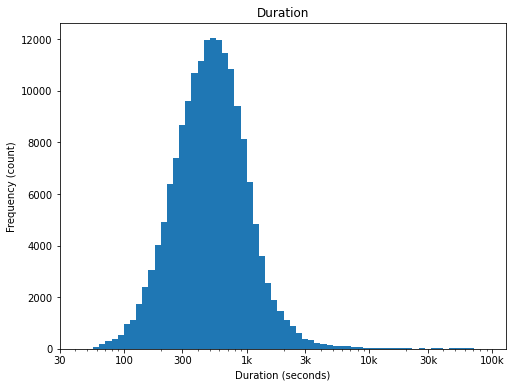

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
bin_size = 0.05
bin= 10 ** np.arange(1.7, np.log10(bike['duration_sec'].max())+bin_size, bin_size)
plt.hist(data=bike, x='duration_sec', bins=bin)
plt.xscale('log')
plt.xticks([3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5], [ '30', '100', '300', '1k', '3k', '10k', '30k', '100k'])
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency (count)')
plt.title('Duration');

## Distribution of Trip Distance 

The distance covered in kilometers during the bike trip has a long_tail, right skew distribution. When plotted on a log scale, the distance distribution is a roughly unimodal distribution and looks a little like a normal distribution with its peak value around 1.0-2.0km.

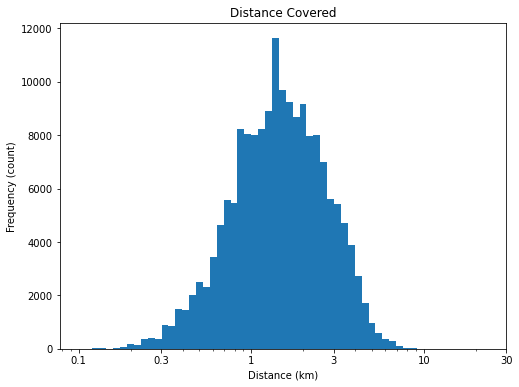

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
bin_size = 0.04
bin= 10 ** np.arange(-1, np.log10(bike['distance_km'].max())+bin_size, bin_size)
plt.hist(data=bike, x='distance_km', bins=bin)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([0.1, 0.3, 1, 3, 1e1, 3e1], ['0.1', '0.3', '1', '3', '10', '30'])
plt.xlabel('Distance (km)')
plt.ylabel('Frequency (count)')
plt.title('Distance Covered');

## Distribution of Age Group and Days

For the age group distribution, the majority of bikers are middle-aged with over 120,000 riders with both adolescents and old-aged adults following in a distance with about 20,000 riders respectively. This is to be expected as the middle-aged adult tend to be more adventurous. There are no children riders with very few seniors represented.

Interestingly, as against expectations, saturdays and sundays which are weekend days have the least rides originating during the period. Most rides occured on thursdays followed by tuesdays with both having avove 30,000 rides.

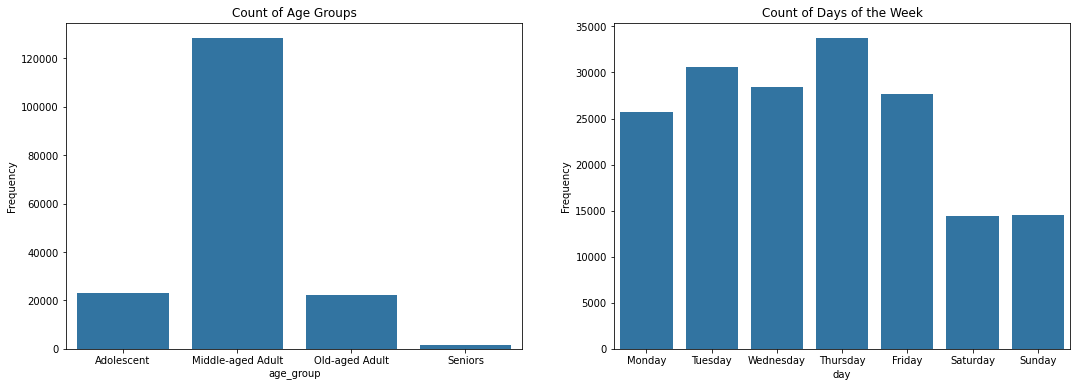

In [9]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
fig, ax = plt.subplots(ncols=2, figsize = [18,6])
g = sns.countplot(data=bike, x='age_group', color=base_color, ax=ax[0])
h = sns.countplot(data=bike, x='day', order=day_order, color=base_color, ax=ax[1])
g.set_ylabel('Frequency')
h.set_ylabel('Frequency')
g.set_title('Count of Age Groups')
h.set_title('Count of Days of the Week');

## Trend Analysis of Number of Trips and Average Distance

A time series plot of the number of trips per day and average distance covered per day shows a positive correlation between the trends. With an increase in number of trips per day, there is a general increase in the average distance per day.

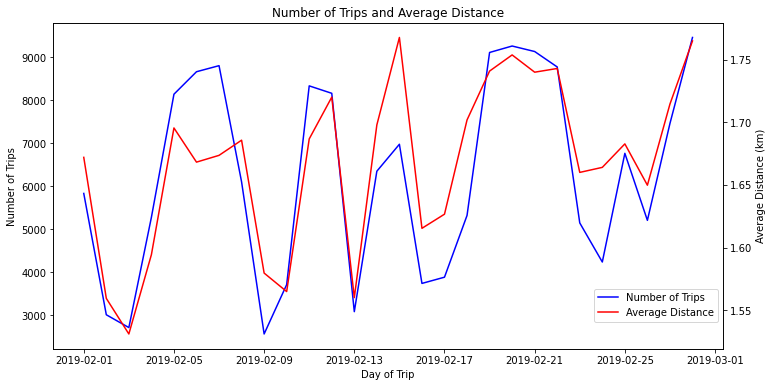

In [10]:
fig, ax1 = plt.subplots(figsize = [12,6])
bike.groupby('start_day')["distance_km"].count().plot(ax=ax1, color='blue', label='Number of Trips')
ax1.set_xlabel('Day of Trip')
ax1.set_ylabel('Number of Trips')
ax1.set_title('Number of Trips and Average Distance')
ax2 = ax1.twinx()
bike.groupby('start_day')["distance_km"].mean().plot(ax=ax2, color='red', label='Average Distance')
ax2.set_ylabel('Average Distance (km)')
fig.legend(loc="upper right", bbox_to_anchor=(1,0.2), bbox_transform=ax1.transAxes);

## Relationship between Distance Covered and Age Group

The riders who are middle-aged adults that is whose ages fall between 25 and 44 years old rode the farthest on average while senior citizens aged 65 years and above rode the shortest distance. This is to be expected considering the middle-aged adults have the strenght when compared to seniors.

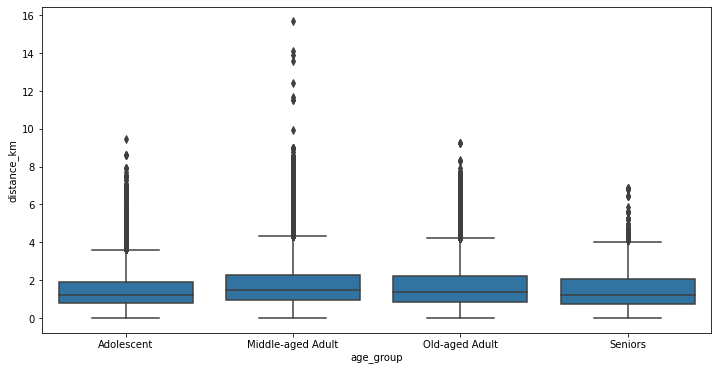

In [11]:
fig, ax1 = plt.subplots(figsize = [12,6])
sns.boxplot(data=bike, y='distance_km', x='age_group', color=base_color);

## Number of Trips per Day and Time

It was observed that most rides started during the mornings and evenings. A closer look by categorising with the days of the week shows that morning and evenings were actually the preferred time for trips but this was solely for the weekdays as most rides started in the afternoons on saturdays and sundays.

What might be the reason for this? Could the bike rides during weekdays be for commute to and from work via different stations?

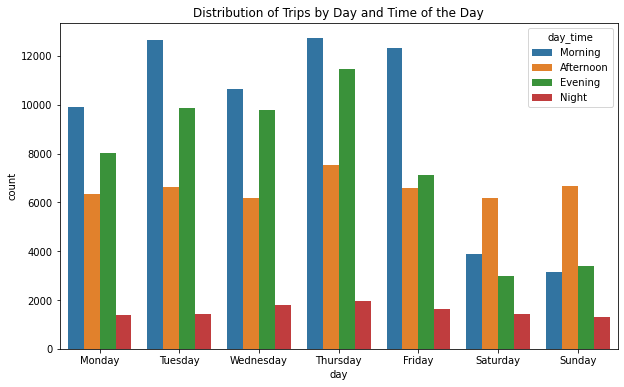

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))  
sns.countplot(data=bike, x='day', hue='day_time', order=day_order, hue_order=time_order)
plt.title('Distribution of Trips by Day and Time of the Day');

## Gender and Day on Measures

The Female riders covered more distance and ride for longer periods across all days and are a little younger than male riders.

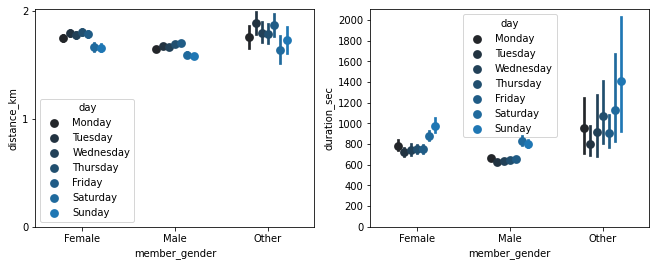

In [13]:
fig, ax = plt.subplots(ncols=2, figsize = [11,4])
sns.pointplot(data=bike, y='distance_km', x='member_gender', hue='day',hue_order=day_order, ax=ax[0],color=base_color,  linestyles = '', dodge = 0.4)
sns.pointplot(data=bike, y='duration_sec', x='member_gender', hue='day', hue_order=day_order, ax=ax[1], color=base_color, linestyles = '', dodge = 0.4)
ax[0].set_yticks(range(0, 3))
ax[1].set_yticks(range(0, 2200, 200));

In [ ]:
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt